In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 #version control

Looking in indexes: https://download.pytorch.org/whl/cu118


# Handling Imports

In [ ]:
import torch
import torch.nn as nn                           #imports the neural network module which contains the nn superclass
import torch.optim as optim                     #imports the optimization algorithms such as gradient descent, adam etc
import torch.nn.functional as F                 #has all the parameter-less functions, imports the activation functions(relu etc), but those can also be found in the nn package
from torch.utils.data import DataLoader         #this provides a dataset class for data representation and a dataloader for iterating over the data among other things.
import torchvision.datasets as datasets         #pytorch comes with datasets which can be imported through this
import torchvision.transforms as transforms     #has methods to perform data augmentation operations such as cropping, resizing, normalization etc.

# Creating a CNN

In [ ]:
class CNN(nn.Module):
  def __init__(self,in_channels=1,num_classes=10):                                                                       #constructor method which creates the object of the written class
    super(CNN, self).__init__()                                                                                          #super method which inherits the methods from the parent nn.Module class
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 8, kernel_size=(3,3), stride=(1,1), padding=(1,1))  #same convolution gives the same dimensions of the image as output
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))                                                           #decreases the image dimensions by 2 times
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))           #same convolution 2
    self.fc1 = nn.Linear(16*7*7, num_classes)                                                                            #fully connectetd layer

  def forward(self, x):              #forward-prop method
    x = F.relu(self.conv1(x))        #relu activation unit after convolution
    x = self.pool1(x)                #max pool layer
    x = F.relu(self.conv2(x))        #convolutuion + activation unit 2
    x = self.pool1(x)                #max pool layer
    x = x.reshape(x.shape[0], -1)    #flatten the output to generate the input for a fully connected layer
    x = self.fc1(x)                  #fully connected layer
    return x

# Check if the model has any errors in the structure

In [ ]:
model = CNN()

#generates a dummy tensor to check the model parameters
x = torch.randn(64, 1, 28, 28)
print(model(x).shape)

torch.Size([64, 10])


# Set Device

In [ ]:
 #sets the device to cuda or cpu depending on the avaialability

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters

In [ ]:
in_channels = 1
batch_size = 64
learning_rate = 10e-4

#output labels
num_classes = 10

#number of epochs the model is training for
num_epochs = 20

# Load Data

In [ ]:
#loading the dataset from pytorch

train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True) #downloads the MNIST dataset if it isn't already installed
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 275777811.09it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35955979.17it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 118784847.59it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21599238.97it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



# Splitting the dataset into train and val set

In [ ]:
#splits the dataset of size 60000 into 50k and 10k respectively for the train and val set

train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_set))
print(len(val_set))

50000
10000


# Initialzing Data Loaders

In [ ]:
#initialzing the data loaders for train,val and test sets respectively

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Initialize Network

In [ ]:
#initializing the model

model = CNN().to(device)

# Loss and Optimizer

In [ ]:
#choosing the loss function and optimizing algorithm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network

In [ ]:
train_losses = []

def train(epoch):

    train_loss=0

    for batch_idx, (data, targets) in enumerate(train_loader):

        #get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        #forward
        scores = model(data)
        loss = criterion(scores, targets)

        #backward
        optimizer.zero_grad() #so it doesnt store gradients from prev back props
        loss.backward()

        #gradient descent or adam step
        optimizer.step()

        #accumulating loss over an epoch
        train_loss += loss.item()

    train_loss = train_loss/len(train_loader)

    # storing the train losses over an epoch in a list
    train_losses.append(train_loss)


# Validation Loss


In [ ]:
# calculating the loss for val_set

val_losses = []

def val(epoch):

   val_loss=0

   with torch.no_grad():
     for batch_idx, (data, targets) in enumerate(val_loader): # dividing into batches is popssibly unecessary (will check later)

        #calling the model with the val data and calculating the loss
        scores = model(data)
        loss = criterion(scores, targets)

        #accumulating val loss over an epoch
        val_loss += loss.item()

   val_loss = val_loss/len(val_loader)

   # storing the validation losses over epochs in a list
   val_losses.append(val_loss)


# Training the model over epochs


In [ ]:
#loops for 20 epochs (will add print statements)

for epoch in range(num_epochs):
    model.train()
    train(epoch)
    model.eval()
    val(epoch)


# Accuracy Check

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

# Checking the accuracy on training, validation and test sets


In [ ]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}") #highest was 99.66
print(f"Accuracy on validation set: {check_accuracy(val_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}") #highest was 98.68

Accuracy on training set: 99.66
Accuracy on validation set: 98.27
Accuracy on test set: 98.68


# Plotting the Train Loss and Validation loss vs number of epochs

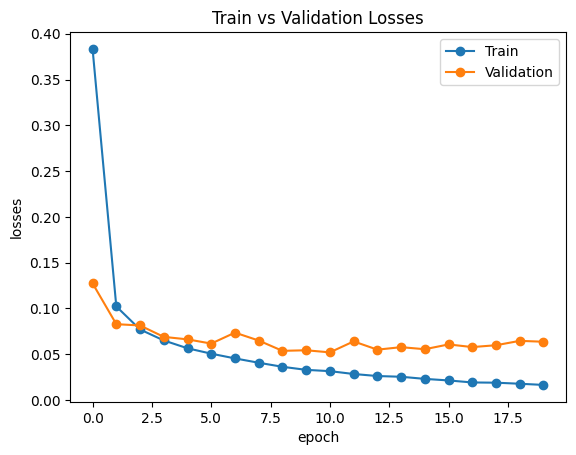

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Validation'])
plt.title('Train vs Validation Losses')

plt.show()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(count_parameters(model))

9098
